# Training Deeptrack's Lode Star Model

## Setup

In [1]:
%matplotlib inline

In [2]:
import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import cv2
import datetime
import io
import datetime
import os
from PIL import Image

## Auxiliar Functions

In [3]:
def save_model(model, checkpoint_path:str, name:str):
    '''Saves the model weights'''
    if not os.path.exists(f'{checkpoint_path}/{datetime.datetime.now()}/'):
        os.makedirs(f'{checkpoint_path}/{name}/')
    model.save_weights(f'{checkpoint_path}/{name}/{name}.h5')

In [4]:
# Defining the image path
DATASET_PATH = '../../data/CellsDataset/original'

In [5]:
def visualize(figsize=(15, 15),**images):
    """Plots images in one row."""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
def get_detection_image(image, detections):
    """ Returns the detections overlaping the image. """
    fig = plt.figure(figsize=(16,16))
    plt.axis('off')
    fig.tight_layout()
    
    plt.imshow(image)
    plt.scatter(detections[:, 1], detections[:, 0], color="g")

    plt.tight_layout()

    buffer = io.BytesIO()

    plt.savefig(buffer, bbox_inches='tight', pad_inches=0.0)

    buffer.seek(0)
    image_pil = Image.open(buffer)

    fig.clf()
    return image_pil

In [7]:
def crop_image(gt, crop_size):
    '''Crops the image'''
    left = 0
    top = 0
    right =  gt.size[0] - crop_size
    bottom =  gt.size[1] - crop_size
    cropped = gt.crop((left, top, right, bottom))
    return cropped

In [8]:
def make_predictions(model, alpha, cutoff):
    for i in range(2, 4):
        image = dt.LoadImage(f"{DATASET_PATH}/{i}.jpg")()._value / 256
        original_image = Image.open(f"{DATASET_PATH}/{i}.jpg")
        image = image[:-400, :-400]
        original_image = crop_image(original_image, 400)
        detections = model.predict_and_detect(image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
        print(len(detections))
        pred, weights = model.predict(image[np.newaxis])
        
        #visualize_detections(image, detections, i, False)
        # visualize_mask(image, detections, i, True)
        # visualize_original(image, i, True)
        detection_img = get_detection_image(original_image, detections).convert('RGB')
        visualize(Detenctions = detection_img)
        

In [9]:
# Model Training hyperparams
args = {
    'num_epochs': 10,
    'batch_size': 8
}

Visualizing the cropped cell used to train the model

(-0.5, 49.5, 49.5, -0.5)

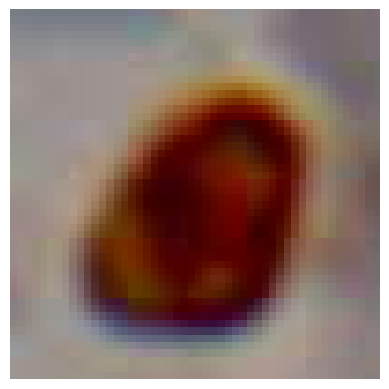

In [10]:
t, x, y, w = (0, 992, 145, 50)
training_image = dt.LoadImage(f"{DATASET_PATH}/1.jpg")() / 256
crop = training_image[y:y+w, x:x+w]
plt.imshow(crop)
plt.axis("off")

In [11]:
model = dt.models.LodeSTAR(input_shape=(None, None, 3))

2024-04-25 22:18:25.066721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 22:18:26.178014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gustavo/tcc/CellDetection-LodeSTAR/tcc_veenv/lib/python3.10/site-packages/cv2/../../lib64:
2024-04-25 22:18:26.178139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-25 22:18:26.328515: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plug

/home/gustavo/tcc/CellDetection-LodeSTAR/tcc_veenv/lib/python3.10/site-packages/deeptrack/features.py:799: UserWarning: Setting dt.Value value as a Image object is likely to lead to performance deterioation. Consider converting it to a numpy array using np.array
  warnings.warn(


<Axes: >

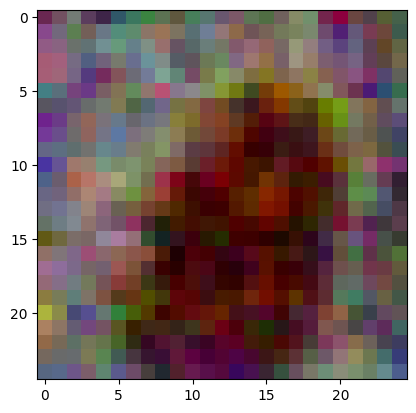

In [12]:
# Applying preprocessing to the image
downsample = 2
train_set =   (
    dt.Value(crop)
    >> dt.Add(lambda: np.random.randn() * 0.1)
    >> dt.AveragePooling((downsample, downsample, 1))
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
    >> dt.Affine(scale=lambda:np.random.uniform(0.7, 1.4, 2), translate=lambda:np.random.uniform(-2, 2, 2))
)
train_set.update().plot()

In [13]:
model.fit(
    train_set,
    epochs=args['num_epochs'],
    batch_size=args['batch_size'],
)

Generating 162 / 160 samples before starting training
Epoch 1/10


/home/gustavo/tcc/CellDetection-LodeSTAR/tcc_veenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.pytorch, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.pytorch, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.deeplay, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.deeplay, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
162/162 [==============================] - 30s 101ms/step - total_loss: 1.1961 - consistency_loss: 0.5311
Epoch 2/10
162/162 [==============================] - 26s 162ms/step - total_loss: 0.5847 - consistency_loss: 0.1938                     
Epoch 3/10
162/162 [==============================] - 51s 315ms/step - total_loss: 0.3965 - consistency_loss: 0.1204                                       
Epoch 4/10
162/162 [==============================] - 55s 339ms/step - total_loss: 0.2609 - consistency_loss: 0.0656                                      
Epoch 5/10
162/162 [==================

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.pytorch, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.pytorch, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-25 22:25:50.105661: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 238788608 exceeds 10% of free system memory.
2024-04-25 22:25:50.838250: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 238788608 exceeds 10% of free system memory.
2024-04-25 22:25:52.663685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 119394304 exceeds 10% of free system memory.
2024-04-25 22:25:52.931266: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 119394304 exceeds 10% of free system memory.
2024-04-25 22:25:53.474051: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 119394304 exceeds 10% of free system memory.


1/1 [==============================] - 7s 7s/step
108
1/1 [==============================] - 40s 40s/step


<Figure size 1600x1600 with 0 Axes>

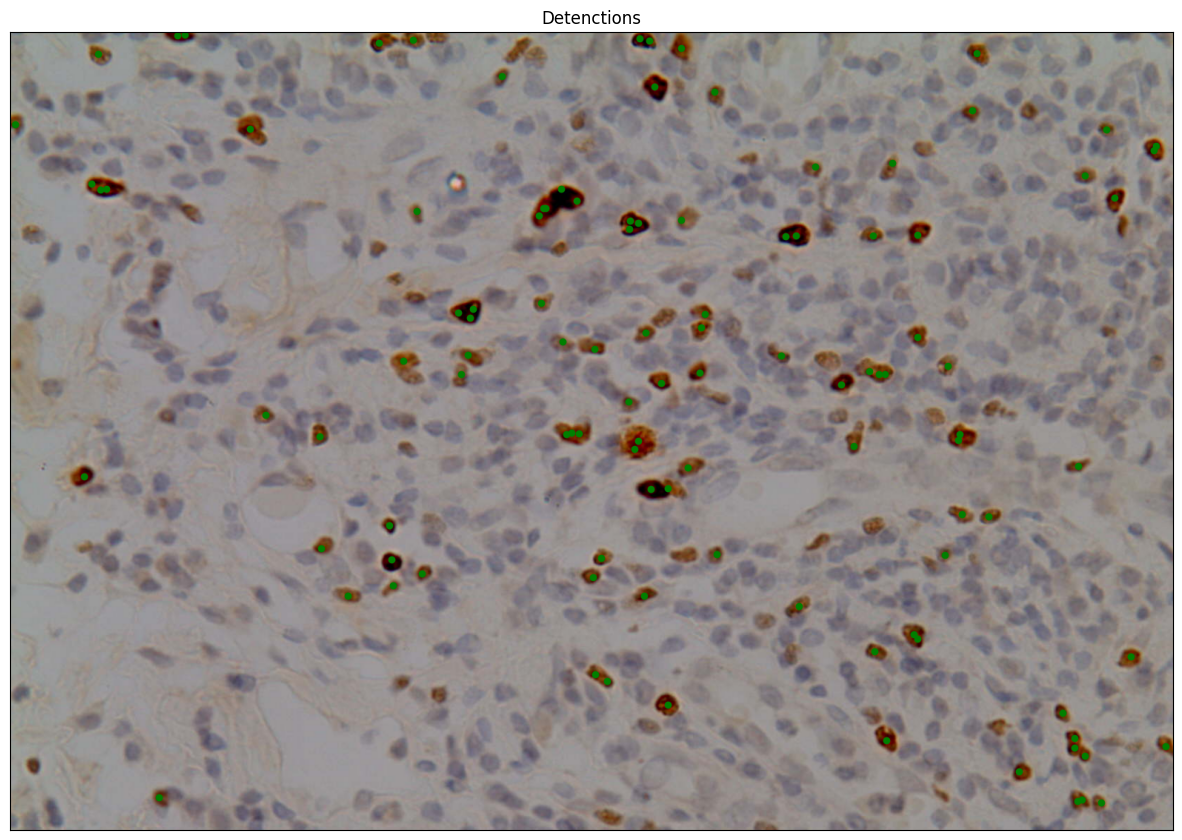

: 

In [14]:
make_predictions(model, alpha = 0.5, cutoff = 0.999)

Saving the model

In [ ]:
CHECKPOINT_PATH = f'../../checkpoints/{args["num_epochs"]}_epochs'
save_model(model, CHECKPOINT_PATH,args['num_epochs'])

FileExistsError: [Errno 17] File exists: '../../checkpoints/2_epochs/2/'